#MSM of the alanine dipeptide

First we import a number of libraries we will need as we run this example

In [1]:
%load_ext autoreload
%matplotlib inline
import math
import numpy as np
import matplotlib.pyplot as plt

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


###Discretizing the trajectory
We start loading the data using the data structures from the `trajectory` module. For this we use the external library [`MDtraj`](http://mdtraj.org), which contains all sorts of methods for parsing and calculating interestign properties of our time-series data.

In [2]:
import mdtraj as md
from mastermsm.trajectory import traj

In [3]:
tr = traj.TimeSeries(top='data/alaTB.gro', traj=['data/protein_only.xtc'])
print tr.mdt

<mdtraj.Trajectory with 10003 frames, 19 atoms, 3 residues, and unitcells>


So does what we have calculated look somewhat like a Ramachandran map?

In [4]:
phi = md.compute_phi(tr.mdt)
psi = md.compute_psi(tr.mdt)
res = [x for x in tr.mdt.topology.residues]

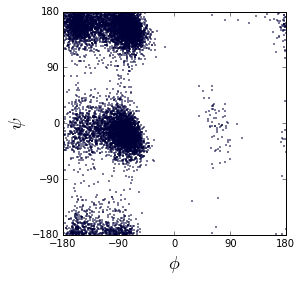

In [5]:
fig,ax = plt.subplots(figsize=(4,4))
ax.plot(180./math.pi*phi[1],180./math.pi*psi[1],'o', markersize=1)
ax.set_xlim(-180,180)
ax.set_ylim(-180,180)
ax.xaxis.set_ticks(range(-180,181,90))
ax.yaxis.set_ticks(range(-180,181,90))

ax.set_xlabel(r'$\phi$', fontsize=18)
ax.set_ylabel(r'$\psi$', fontsize=18)

Next we proceed to discretize the trajectory based on the Ramachandran angles.

In [6]:
tr.discretize(states=['A', 'E'])

For plotting we convert helical configurations in 1 and beta in 0.

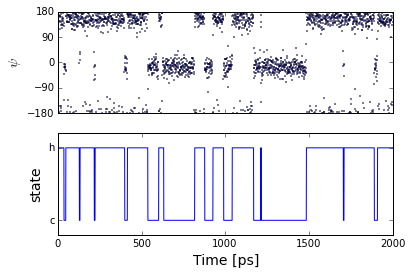

In [7]:
y = [0 if x == 'A' else 1 for x in tr.distraj]
fig, (ax1, ax2) = plt.subplots(2,1, sharex=True)
ax1.plot(psi[1]*180/math.pi,'o', markersize=1)
ax2.plot(y)

ax1.set_ylabel(r'$\psi$', fontsize=14)
ax1.set_xlim(0,2000)
ax1.set_ylim(-180,180)
ax1.yaxis.set_ticks(range(-180,181,90))

ax2.set_ylabel(r'state', fontsize=14)
ax2.set_xlim(0,2000)
ax2.set_ylim(-0.2,1.2)
ax2.yaxis.set_ticks([0,1])
labels = [item.get_text() for item in ax2.get_xticklabels()]
labels[0] = 'c'
labels[1] = 'h'
ax2.set_yticklabels(labels)

ax2.set_xlabel('Time [ps]')
ax2.set_xlabel(r'Time [ps]', fontsize=14)

In the plot we see how we go from the time series of continuous torsion angles converts into a time series of discrete states. We can obtain a list of states in the following way.

In [8]:
tr.find_keys()
tr.keys
tr.file_name

['data/protein_only.xtc']

###Building the master equation model
After having load our trajectory using the functionalities from the `trajectory` module we start building the master equation model. For this, we make use of the `msm` module. We feed the same trajectory twice to check that functionality with more than one trajectory works alright.

In [9]:
from mastermsm.msm import msm
msm_alaTB = msm.SuperMSM([tr, tr])


 Building MSM from 
[['data/protein_only.xtc'], ['data/protein_only.xtc']]
     # states: 2


In [10]:
for i in [1, 2, 5, 10, 20, 50]:
    msm_alaTB.do_msm(i)

We first construct the MSM at multiple lag times, to see at which point the relaxation times are sufficiently well converged.

In [12]:
msm_alaTB.convergence_test(time=[1, 2, 5, 10, 20, 50], error=True)


    Generating MSM at lag time: 1

    Count matrix:
[[11516   144]
 [  146  8196]]

    Transition matrix:
[[ 0.98748071  0.01726619]
 [ 0.01251929  0.98273381]]

    Generating MSM at lag time: 2

    Count matrix:
[[11370   288]
 [  292  8050]]

    Transition matrix:
[[ 0.97496141  0.03454066]
 [ 0.02503859  0.96545934]]

    Generating MSM at lag time: 5

    Count matrix:
[[10970   682]
 [  692  7650]]

    Transition matrix:
[[ 0.94066198  0.0818531 ]
 [ 0.05933802  0.9181469 ]]

    Generating MSM at lag time: 10

    Count matrix:
[[10390  1252]
 [ 1272  7070]]

    Transition matrix:
[[ 0.8909278  0.1504446]
 [ 0.1090722  0.8495554]]

    Generating MSM at lag time: 20

    Count matrix:
[[9468 2154]
 [2176 6166]]

    Transition matrix:
[[ 0.81312264  0.25889423]
 [ 0.18687736  0.74110577]]

    Generating MSM at lag time: 50

    Count matrix:
[[8164 3420]
 [3476 4844]]

    Transition matrix:
[[ 0.70137457  0.41384318]
 [ 0.29862543  0.58615682]]


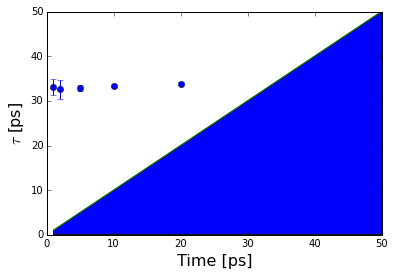

In [31]:
tau_vs_lagt = np.array([[x,msm_alaTB.msms[x].tauT[0],msm_alaTB.msms[x].tau_std[0]] \
               for x in sorted(msm_alaTB.msms.keys())])
fig, ax = plt.subplots()
ax.errorbar(tau_vs_lagt[:,0],tau_vs_lagt[:,1],fmt='o', yerr=tau_vs_lagt[:,2])
ax.plot(tau_vs_lagt[:,0],tau_vs_lagt[:,0])
ax.fill_between(tau_vs_lagt[:,0], 1e-1, tau_vs_lagt[:,0],face)

ax.set_xlabel(r'Time [ps]', fontsize=16)
ax.set_ylabel(r'$\tau$ [ps]', fontsize=16)
#ax.set_yscale('log')

We check whether the approximate method to calculate the rate works well.

###Calculation of the rate matrix
From the transition matrix we can calculate the rate matrix. One possibility is to use an approximate method based simply on a Taylor expansion. We can check whether our approximate method gives a good result.

In [ ]:
fig, ax = plt.subplots(1,2, figsize=(6.5,3))
for i in [1, 2, 5, 10, 20, 50]:
    ax[0].errorbar(msm_alaTB.msms[i].tauT, msm_alaTB.msms[i].tauK, fmt='o', xerr=msm_alaTB.msms[i].tau_std)
    ax[1].errorbar(msm_alaTB.msms[i].peqT, msm_alaTB.msms[i].peqK, fmt='o', xerr=msm_alaTB.msms[i].peq_std)
ax[0].plot([10,100],[10,100],'--', alpha=0.4)
ax[1].plot([0.1,1],[0.1,1],'--', alpha=0.4)
ax[0].set_xscale('log')
ax[0].set_yscale('log')
ax[1].set_xscale('log')
ax[1].set_yscale('log')
ax[0].set_xlabel(r'$\tau_T$', fontsize=16)
ax[0].set_ylabel(r'$\tau_K$', fontsize=16)
ax[1].set_xlabel(r'$p_T$', fontsize=16)
ax[1].set_ylabel(r'$p_K$', fontsize=16)
plt.tight_layout(pad=0.4, w_pad=3)

Clearly, for lag times up to 10 ps the approximation is reasonable for the relaxation times, and it is good at all lag times for the equilibrium probabilities.